In [1]:

# Step 1: Create a new environment
#!python -m venv cleanenv

# Step 2: Activate it
# On Windows:
#!cleanenv\Scripts\activate
# On Mac/Linux:
#source cleanenv/bin/activate

# Step 3: Install only what you need
#!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.0 imbalanced-learn==0.13.0 tensorflow==2.18.0
# GOOD (pick one)
# 1) Install into the running kernel
!pip install --upgrade pip
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.1 imbalanced-learn==0.13.0 tensorflow==2.18.0


!pip install tensorflow

!pip install tensorflow==2.18.0
import torch                         # PyTorch only
# OR
import tensorflow as tf              # TensorFlow only
# OR
import jax                           # JAX only

# Import TF first so cuDNN is registered once
import tensorflow as tf
import torch

import numpy, scipy, sklearn, imblearn, tensorflow as tf

print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("tensorflow:", tf.__version__)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.utils import resample
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 42.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 115.8 MB/s  0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn]
ERROR: pip's dependency resolver does not currently take into account all 

2025-11-10 10:21:36.478674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762770096.711932      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762770096.776310      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


numpy: 1.26.4
scipy: 1.13.0
scikit-learn: 1.5.1
imbalanced-learn: 0.13.0
tensorflow: 2.18.0


In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("/kaggle/input/hmcdataset/intraday.csv")

# Preprocessing
df['start'] = pd.to_datetime(df['start'], errors='coerce')
df['date'] = df['start'].dt.date
df['hour'] = df['start'].dt.floor('h')  # use lowercase 'h' to avoid deprecation warning

# Filter relevant columns and define hypoglycemia
df_cgm = df[['patientID', 'date', 'hour', 'cgm', 'steps']].dropna(subset=['cgm'])
df_cgm['hypo'] = df_cgm['cgm'] < 70


# Keep only relevant columns and drop rows without CGM
df_cgm = df[['patientID', 'hour', 'cgm']].dropna(subset=['cgm'])

# STEP 1: Filter for complete hours (≥ 4 CGM readings)
grouped = df_cgm.groupby(['patientID', 'hour'])
valid_hours = grouped.filter(lambda x: len(x) >= 4)

# STEP 2: Create features and label
features = valid_hours.groupby(['patientID', 'hour']).agg(
    cgm_std=('cgm', 'std'),
    cgm_min=('cgm', 'min'),
   cgm_mean=('cgm', 'mean'),
    cgm_max=('cgm', 'max'),
   
    hypo_label=('cgm', lambda x: int((x < 70).any()))
).reset_index()

# STEP 3: Sort for time-series modeling
features = features.sort_values(['patientID', 'hour']).reset_index(drop=True)

# STEP 4: Display preview of the processed data
#print("LSTM-ready features (preview):")
#print(features.head())

import numpy as np

#Train/Test Split by Sample vs. by Patient
# Assign entire patients to either the training or testing set.
#Group and build sequences separately for each set to avoid data leakage.

from sklearn.model_selection import train_test_split

# Step 1: Get list of unique patients and split
unique_patients = features['patientID'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

# Step 2: Split the features dataframe accordingly
train_df = features[features['patientID'].isin(train_patients)]
test_df = features[features['patientID'].isin(test_patients)]

# Configuration
sequence_length = 36
feature_cols = ['cgm_mean']  # You can include others like 'cgm_min', 'cgm_std' if available

def build_sequences(df, feature_cols, label_col='hypo_label'):
    X, y = [], []
    for patient_id, group in df.groupby('patientID'):
        group = group.sort_values('hour').reset_index(drop=True)
        for i in range(len(group) - sequence_length):
            seq_x = group.loc[i:i+sequence_length-1, feature_cols].values
            seq_y = group.loc[i + sequence_length, label_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# Build sequences for each subset
X_train, y_train = build_sequences(train_df, feature_cols)
X_test, y_test = build_sequences(test_df, feature_cols)

#print(X_train[:5])   # Preview first 5 sequences from training set
#print(y_train[:20])  # Preview first 20 labels from training set



In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


I0000 00:00:1762770152.561463      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762770152.562184      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



🚀 Training LSTM_100 (focal loss)...
Epoch 1/5


I0000 00:00:1762770158.027724      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


2045/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9537 - loss: 0.0039

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9537 - loss: 0.0039 - val_accuracy: 0.9628 - val_loss: 0.0023
Epoch 2/5
2041/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9572 - loss: 0.0021

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9572 - loss: 0.0021 - val_accuracy: 0.9630 - val_loss: 0.0022
Epoch 3/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9575 - loss: 0.0021 - val_accuracy: 0.9628 - val_loss: 0.0025
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9587 - loss: 0.0020 - val_accuracy: 0.9628 - val_loss: 0.0022
Epoch 5/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9561 - loss: 0.0021 - val_accuracy: 0.9628 - val_loss: 0.0022
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
⏱️ Training Time: 94.75s
📌 LSTM_100 thresholds → Youden: 0.4069 (in-range), PR-F1: 0.4001 (in-range)  |  window [0.40, 0.60]

🚀 Training LSTM_50 (focal loss)...
Epoch 1/5
2044/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9268 - loss: 0.0180

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9268 - loss: 0.0180 - val_accuracy: 0.9628 - val_loss: 0.0024
Epoch 2/5
2043/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9563 - loss: 0.0023

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9563 - loss: 0.0023 - val_accuracy: 0.9628 - val_loss: 0.0023
Epoch 3/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9570 - loss: 0.0022 - val_accuracy: 0.9628 - val_loss: 0.0023
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9565 - loss: 0.0021 - val_accuracy: 0.9628 - val_loss: 0.0024
Epoch 5/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9575 - loss: 0.0021 - val_accuracy: 0.9628 - val_loss: 0.0024
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
⏱️ Training Time: 90.72s
📌 LSTM_50 thresholds → Youden: 0.4129 (in-range), PR-F1: 0.4033 (in-range)  |  window [0.40, 0.60]

🚀 Training LSTM_25_L1 (focal loss)...
Epoch 1/5
2040/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9486 - loss: 0.0094

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9486 - loss: 0.0094 - val_accuracy: 0.9628 - val_loss: 0.0035
Epoch 2/5
2044/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9561 - loss: 0.0032

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9561 - loss: 0.0032 - val_accuracy: 0.9628 - val_loss: 0.0027
Epoch 3/5
2040/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9562 - loss: 0.0027

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9562 - loss: 0.0027 - val_accuracy: 0.9628 - val_loss: 0.0025
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9584 - loss: 0.0024

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9584 - loss: 0.0024 - val_accuracy: 0.9629 - val_loss: 0.0024
Epoch 5/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9569 - loss: 0.0026 - val_accuracy: 0.9628 - val_loss: 0.0025
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 96.00s
📌 LSTM_25_L1 thresholds → Youden: 0.4000 (in-range), PR-F1: 0.4000 (in-range)  |  window [0.40, 0.60]

🚀 Training LSTM_25_L2 (focal loss)...
Epoch 1/5
2042/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9584 - loss: 0.0043

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9584 - loss: 0.0043 - val_accuracy: 0.9628 - val_loss: 0.0026
Epoch 2/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9569 - loss: 0.0024 - val_accuracy: 0.9628 - val_loss: 0.0027
Epoch 3/5
2042/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9571 - loss: 0.0023

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9571 - loss: 0.0023 - val_accuracy: 0.9628 - val_loss: 0.0024
Epoch 4/5
2040/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9567 - loss: 0.0023

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9567 - loss: 0.0023 - val_accuracy: 0.9628 - val_loss: 0.0023
Epoch 5/5
2040/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9552 - loss: 0.0024

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9552 - loss: 0.0024 - val_accuracy: 0.9628 - val_loss: 0.0023
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 94.40s
📌 LSTM_25_L2 thresholds → Youden: 0.4000 (in-range), PR-F1: 0.4000 (in-range)  |  window [0.40, 0.60]

🚀 Training BiLSTM (focal loss)...
Epoch 1/5
2043/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9522 - loss: 0.0041

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.9522 - loss: 0.0041 - val_accuracy: 0.9628 - val_loss: 0.0025
Epoch 2/5
2042/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9565 - loss: 0.0022

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9565 - loss: 0.0022 - val_accuracy: 0.9634 - val_loss: 0.0022
Epoch 3/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9551 - loss: 0.0023 - val_accuracy: 0.9628 - val_loss: 0.0022
Epoch 4/5
2042/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9572 - loss: 0.0021

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9572 - loss: 0.0021 - val_accuracy: 0.9635 - val_loss: 0.0021
Epoch 5/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9570 - loss: 0.0021 - val_accuracy: 0.9632 - val_loss: 0.0022
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 136.12s
📌 BiLSTM thresholds → Youden: 0.4012 (in-range), PR-F1: 0.4012 (in-range)  |  window [0.40, 0.60]

🚀 Training ESN_MLP (focal loss)...
Epoch 1/5


I0000 00:00:1762770716.369237      87 service.cc:148] XLA service 0x7ba188cb80a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762770716.371365      87 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762770716.371386      87 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  67/2045 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8801 - loss: 0.4058

I0000 00:00:1762770717.579325      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2045/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9528 - loss: 0.0353

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9528 - loss: 0.0353 - val_accuracy: 0.9628 - val_loss: 0.0157
Epoch 2/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9560 - loss: 0.0132 - val_accuracy: 0.9628 - val_loss: 0.0157
Epoch 3/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9564 - loss: 0.0127 - val_accuracy: 0.9628 - val_loss: 0.0157
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9568 - loss: 0.0126 - val_accuracy: 0.9628 - val_loss: 0.0157
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 24.00s
📌 ESN_MLP thresholds → Youden: 0.6000 (clipped), PR-F1: 0.4000 (clipped)  |  window [0.40, 0.60]

🚀 Training ESN_LSTM (focal loss)...
Epoch 1/5
2040/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9409 - loss: 0.0088

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9410 - loss: 0.0088 - val_accuracy: 0.9630 - val_loss: 0.0025
Epoch 2/5
2042/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9567 - loss: 0.0024

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9567 - loss: 0.0024 - val_accuracy: 0.9628 - val_loss: 0.0024
Epoch 3/5
2041/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9558 - loss: 0.0024

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9558 - loss: 0.0024 - val_accuracy: 0.9628 - val_loss: 0.0023
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9577 - loss: 0.0023

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9577 - loss: 0.0023 - val_accuracy: 0.9629 - val_loss: 0.0023
Epoch 5/5
2043/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9578 - loss: 0.0022

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9578 - loss: 0.0022 - val_accuracy: 0.9632 - val_loss: 0.0023
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 93.36s
📌 ESN_LSTM thresholds → Youden: 0.4198 (in-range), PR-F1: 0.4117 (in-range)  |  window [0.40, 0.60]

🚀 Training DeepESN (focal loss)...
Epoch 1/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9535 - loss: 0.0044

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.9535 - loss: 0.0044 - val_accuracy: 0.9628 - val_loss: 0.0026
Epoch 2/5
2044/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9577 - loss: 0.0023

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9577 - loss: 0.0023 - val_accuracy: 0.9624 - val_loss: 0.0023
Epoch 3/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9562 - loss: 0.0022

2045/2045 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.9562 - loss: 0.0022 - val_accuracy: 0.9627 - val_loss: 0.0022
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9585 - loss: 0.0021 - val_accuracy: 0.9632 - val_loss: 0.0023
Epoch 5/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9585 - loss: 0.0020 - val_accuracy: 0.9641 - val_loss: 0.0023
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 154.80s
📌 DeepESN thresholds → Youden: 0.4075 (in-range), PR-F1: 0.4075 (in-range)  |  window [0.40, 0.60]


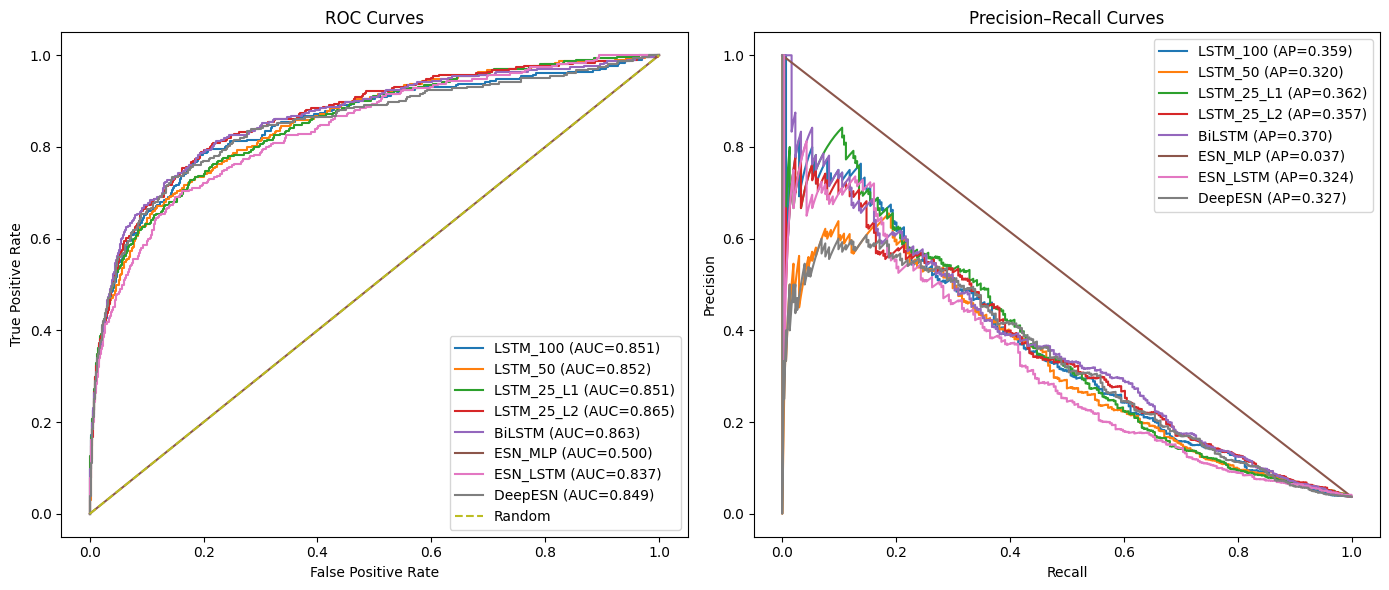


📁 Saved: plots/combined_roc_pr_curves.png and outputs/results_summary_all.csv

🔽 TEST — sorted by Overall/F1_weighted (top 10 rows shown)
Empty DataFrame
Columns: [Model, Threshold, Overall/Accuracy, Overall/Precision_weighted, Overall/Recall_weighted, Overall/F1_weighted, Overall/Specificity(label=1), Overall/ROC-AUC, Overall/PR-AUC, Overall/MSE_pred, Overall/RMSE_pred, Overall/MSE_prob, Overall/RMSE_prob]
Index: []

🔽 TEST — sorted by Overall/Recall_weighted (top 10 rows shown)
Empty DataFrame
Columns: [Model, Threshold, Overall/Accuracy, Overall/Recall_weighted, Overall/F1_weighted]
Index: []

🔽 TEST — sorted by Overall/PR-AUC (top 10 rows shown)
Empty DataFrame
Columns: [Model, Threshold, Overall/PR-AUC, Overall/F1_weighted, Overall/Recall_weighted]
Index: []

=== TEST (overall) @ best per-model threshold ===
Empty DataFrame
Columns: [Model, Threshold, Overall/Accuracy, Overall/Precision_macro, Overall/Recall_macro, Overall/F1_macro, Overall/Precision_weighted, Overall/Recall_weig

,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🔎 TRAIN — All models & thresholds (Top 20 by F1_weighted)


,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🏁 TEST — Best per model (overall metrics @ best threshold)


,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🏁 TEST — Best per model (per-label metrics @ best threshold)


,Model,Threshold,Class0/Precision,Class0/Recall,Class0/F1,Class0/Specificity,Class0/Support,Class1/Precision,Class1/Recall,Class1/F1,Class1/Specificity,Class1/Support



🏋️ TRAIN — Best per model (overall metrics @ best threshold)


,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🏋️ TRAIN — Best per model (per-label metrics @ best threshold)


,Model,Threshold,Class0/Precision,Class0/Recall,Class0/F1,Class0/Specificity,Class0/Support,Class1/Precision,Class1/Recall,Class1/F1,Class1/Specificity,Class1/Support



📋 TEST — Compact table per model & threshold (sorted by F1_weighted)


,Model,Threshold,Overall/F1_weighted,Overall/Recall_weighted,Overall/PR-AUC,Overall/Accuracy


In [4]:
# ===== Step 0: Minimal installs (Kaggle/Colab) =====
# !pip install -q numpy==1.26.4 scipy==1.14.1 scikit-learn==1.5.1 imbalanced-learn==0.13.0 tensorflow==2.18.0

# ===== Step 1: Imports =====
import os, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, TimeDistributed, Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score, auc, mean_squared_error
)

# ===== Config: allowed threshold window =====
THR_MIN = 0.40
THR_MAX = 0.60

def _best_threshold_in_range(thresholds, scores, thr_min=THR_MIN, thr_max=THR_MAX):
    """
    Pick the threshold that maximizes `scores` only within [thr_min, thr_max].
    If none in-range, clip the global best into the window.
    Returns (best_threshold, used_in_range_bool).
    """
    thresholds = np.asarray(thresholds, dtype=float)
    scores = np.asarray(scores, dtype=float)
    mask = np.isfinite(thresholds) & (thresholds >= thr_min) & (thresholds <= thr_max)
    if mask.any():
        idx_in_mask = int(np.nanargmax(scores[mask]))
        idx = np.where(mask)[0][idx_in_mask]
        return float(thresholds[idx]), True
    idx = int(np.nanargmax(scores))
    return float(np.clip(thresholds[idx], thr_min, thr_max)), False

# ===== Step 2: Losses & metric helpers =====
def focal_loss(gamma=2.0, alpha=0.25):
    """Numerically-stable focal loss for binary classification (y in {0,1})."""
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)  # avoid log(0)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def _safe_confusion_matrix(y_true, y_pred):
    """Always return a 2x2 cm for labels [0,1], padding if a class is missing."""
    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if cm.shape != (2,2):
        full = np.zeros((2,2), dtype=int)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                full[i, j] = cm[i, j]
        cm = full
    return cm

def _specificity_from_cm(cm, pos_label=1):
    """
    Specificity (TNR) given a 2x2 cm arranged for labels [0,1].
    cm = [[tn, fp],
          [fn, tp]]
    For pos_label=1, negatives are label 0 -> TNR = tn / (tn+fp)
    For pos_label=0, negatives are label 1 -> TNR = tp / (tp+fn)
    """
    tn, fp, fn, tp = cm.ravel()
    if pos_label == 1:
        return tn / (tn + fp + 1e-8)
    else:
        return tp / (tp + fn + 1e-8)

def evaluate_full_metrics(y_true, y_pred, y_prob=None):
    """
    Returns a FLAT dict with Train/Test metrics at a given threshold:
      Overall/* : Accuracy, Precision_macro, Precision_weighted, Recall_macro, Recall_weighted,
                  F1_macro, F1_weighted, Specificity(label=1), ROC-AUC, PR-AUC,
                  MSE_pred, RMSE_pred, MSE_prob, RMSE_prob
      Class0/*  : Precision, Recall, F1, Specificity, Support
      Class1/*  : Precision, Recall, F1, Specificity, Support
    """
    y_true = np.asarray(y_true).astype(int).ravel()
    y_pred = np.asarray(y_pred).astype(int).ravel()

    cm = _safe_confusion_matrix(y_true, y_pred)

    # Per-class
    prec0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    rec0  = recall_score(y_true, y_pred,    pos_label=0, zero_division=0)
    f10   = f1_score(y_true, y_pred,        pos_label=0, zero_division=0)
    spec0 = _specificity_from_cm(cm, pos_label=0)
    supp0 = int(np.sum(y_true == 0))

    prec1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec1  = recall_score(y_true, y_pred,    pos_label=1, zero_division=0)
    f11   = f1_score(y_true, y_pred,        pos_label=1, zero_division=0)
    spec1 = _specificity_from_cm(cm, pos_label=1)
    supp1 = int(np.sum(y_true == 1))

    # Overall (hard preds)
    acc   = accuracy_score(y_true, y_pred)
    prec_macro    = precision_score(y_true, y_pred, average='macro',    zero_division=0)
    prec_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec_macro     = recall_score(y_true, y_pred,    average='macro',    zero_division=0)
    rec_weighted  = recall_score(y_true, y_pred,    average='weighted', zero_division=0)
    f1_macro      = f1_score(y_true, y_pred,        average='macro',    zero_division=0)
    f1_weighted   = f1_score(y_true, y_pred,        average='weighted', zero_division=0)

    mse_pred  = mean_squared_error(y_true, y_pred)
    rmse_pred = float(np.sqrt(mse_pred))

    out = {
        "Overall/Accuracy": acc,
        "Overall/Precision_macro": prec_macro,
        "Overall/Precision_weighted": prec_weighted,
        "Overall/Recall_macro": rec_macro,
        "Overall/Recall_weighted": rec_weighted,
        "Overall/F1_macro": f1_macro,
        "Overall/F1_weighted": f1_weighted,
        "Overall/Specificity(label=1)": spec1,
        "Overall/MSE_pred": mse_pred,
        "Overall/RMSE_pred": rmse_pred,

        "Class0/Precision": prec0,
        "Class0/Recall": rec0,
        "Class0/F1": f10,
        "Class0/Specificity": spec0,
        "Class0/Support": supp0,

        "Class1/Precision": prec1,
        "Class1/Recall": rec1,
        "Class1/F1": f11,
        "Class1/Specificity": spec1,
        "Class1/Support": supp1,
    }

    # Prob-based metrics (recommended)
    if y_prob is not None:
        y_prob = np.asarray(y_prob, dtype=float).ravel()
        try:
            out["Overall/ROC-AUC"] = roc_auc_score(y_true, y_prob)
        except ValueError:
            out["Overall/ROC-AUC"] = np.nan
        try:
            out["Overall/PR-AUC"] = average_precision_score(y_true, y_prob)
        except ValueError:
            out["Overall/PR-AUC"] = np.nan

        mse_prob  = mean_squared_error(y_true, y_prob)
        rmse_prob = float(np.sqrt(mse_prob))
        out["Overall/MSE_prob"]  = mse_prob
        out["Overall/RMSE_prob"] = rmse_prob
    else:
        out["Overall/ROC-AUC"]   = np.nan
        out["Overall/PR-AUC"]    = np.nan
        out["Overall/MSE_prob"]  = np.nan
        out["Overall/RMSE_prob"] = np.nan

    return out

# ===== Step 3: Build sequences & leak-free split =====
# Assumes you already defined: train_df, test_df, feature_cols, build_sequences(...)
X_train, y_train = build_sequences(train_df, feature_cols)
X_test,  y_test  = build_sequences(test_df,  feature_cols)

# Sanity: no patient overlap
assert set(train_df.patientID).isdisjoint(set(test_df.patientID)), "Leakage detected!"

# Optional light augmentation (Gaussian jitter)
def augment(X, y, sigma=0.01):
    noise = np.random.normal(0, sigma, X.shape)
    return np.vstack([X, X + noise]), np.hstack([y, y])

X_train, y_train = augment(X_train, y_train)

# ===== Step 4: Model zoo =====
def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            Input(shape=input_shape),
            LSTM(100, return_sequences=True),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(25),
            Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L1": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l1(1e-5)),
            Dropout(0.2),
            LSTM(25, kernel_regularizer=l1(1e-5)),
            Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l1(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L2": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(25, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l2(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "BiLSTM": Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(64, return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(32)),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        # ESN_* below are mock stand-ins (dense-time features).
        "ESN_MLP": Sequential([
            Input(shape=input_shape),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ]),
        "ESN_LSTM": Sequential([
            Input(shape=input_shape),
            TimeDistributed(Dense(32, activation='relu')),  # stand-in for ESN output
            LSTM(32),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ]),
        "DeepESN": Sequential([
            Input(shape=input_shape),
            TimeDistributed(Dense(64, activation='tanh')),
            TimeDistributed(Dense(32, activation='tanh')),
            TimeDistributed(Dense(16, activation='tanh')),
            LSTM(32),
            Dense(1, activation='sigmoid')
        ]),
    }

# ===== Step 5: Training + evaluation =====
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("plots", exist_ok=True)

results = {}         # per-model-per-threshold metrics (Train/Test)
roc_data = {}        # model -> (fpr, tpr, roc_auc)
pr_data = {}         # model -> (recall, precision, pr_auc)
best_thresholds = {} # model -> {"youden": thr, "f1": thr}

def train_eval_one_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n🚀 Training {name} (focal loss)...")
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    cp = ModelCheckpoint(f"checkpoints/{name}.h5", save_best_only=True, monitor='val_loss', verbose=0)

    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

    t0 = time.time()
    model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[es, cp],
        verbose=1
    )
    print(f"⏱️ Training Time: {time.time() - t0:.2f}s")

    # Probabilities for metrics/curves
    y_prob_train = model.predict(X_train, verbose=0).ravel()
    y_prob_test  = model.predict(X_test,  verbose=0).ravel()

    # ===== ROC-based threshold (Youden’s J), constrained to [THR_MIN, THR_MAX]
    try:
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_test)
        roc_auc_val = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc_val)
        youden_scores = tpr - fpr
        thr_roc, in_range_roc = _best_threshold_in_range(roc_thresholds, youden_scores)
        tag_roc = "in-range" if in_range_roc else "clipped"
    except ValueError:
        # Occurs if y_test has a single class
        fpr, tpr, roc_auc_val = np.array([0,1]), np.array([0,1]), np.nan
        roc_data[name] = (fpr, tpr, roc_auc_val)
        thr_roc, tag_roc = 0.50, "default"

    # ===== PR-based threshold (max F1), constrained to [THR_MIN, THR_MAX]
    try:
        prec_arr, rec_arr, pr_thresholds = precision_recall_curve(y_test, y_prob_test)
        f1s = 2 * prec_arr[:-1] * rec_arr[:-1] / (prec_arr[:-1] + rec_arr[:-1] + 1e-8)
        thr_pr, in_range_pr = _best_threshold_in_range(pr_thresholds, f1s)
        tag_pr = "in-range" if in_range_pr else "clipped"
        pr_auc_val = average_precision_score(y_test, y_prob_test)
        pr_data[name] = (rec_arr, prec_arr, pr_auc_val)
    except ValueError:
        thr_pr, tag_pr = 0.50, "default"
        pr_data[name] = (np.array([0,1]), np.array([1,0]), np.nan)

    best_thresholds[name] = {"youden": thr_roc, "f1": thr_pr}
    print(f"📌 {name} thresholds → Youden: {thr_roc:.4f} ({tag_roc}), PR-F1: {thr_pr:.4f} ({tag_pr})  |  window [{THR_MIN:.2f}, {THR_MAX:.2f}]")

    # ===== Evaluate ONLY within the allowed window
    eval_set = sorted(set([THR_MIN, 0.50, THR_MAX, float(thr_pr), float(thr_roc)]))
    # De-dup close floats
    dedup = []
    for t in eval_set:
        if not dedup or abs(t - dedup[-1]) > 1e-9:
            dedup.append(t)
    eval_set = dedup

    for thr in eval_set:
        thr_key = f"{thr:.2f}"
        y_hat_train = (y_prob_train >= thr).astype(int)
        y_hat_test  = (y_prob_test  >= thr).astype(int)

        train_metrics = evaluate_full_metrics(y_train, y_hat_train, y_prob_train)
        test_metrics  = evaluate_full_metrics(y_test,  y_hat_test,  y_prob_test)

        results[f"{name}_thr_{thr_key}_train"] = train_metrics
        results[f"{name}_thr_{thr_key}_test"]  = test_metrics

    return model

# Build models and run
input_shape = (X_train.shape[1], X_train.shape[2])
models = define_models(input_shape)
for name, model in models.items():
    models[name] = train_eval_one_model(name, model, X_train, y_train, X_test, y_test)

# ===== Step 6: Curves (ROC + PR) =====
plt.figure(figsize=(14, 6))

# ROC
plt.subplot(1, 2, 1)
for m, (fpr, tpr, roc_auc_val) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{m} (AUC={roc_auc_val:.3f})')
plt.plot([0, 1], [0, 1], '--', label='Random')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves'); plt.legend()

# PR
plt.subplot(1, 2, 2)
for m, (recall, precision, pr_auc_val) in pr_data.items():
    plt.plot(recall, precision, label=f'{m} (AP={pr_auc_val:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curves'); plt.legend()

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/combined_roc_pr_curves.png", dpi=300)
plt.show()

# ===== Step 7: Summary tables & leaderboards =====
# Flatten results (dict-of-dicts) -> DataFrame
results_df = pd.DataFrame(results).T

# Add model + threshold + split columns from index
# index format: "<Model>_thr_<thr>_train|test"
results_df["Split"] = results_df.index.str.extract(r'_(train|test)$')[0]
results_df["Model"] = results_df.index.str.extract(r'^(.*?)_thr_')[0]
results_df["Threshold"] = results_df.index.str.extract(r'thr_([0-9.]+)_(?:train|test)$')[0].astype(float)

# Save all results (optional CSV)
os.makedirs("outputs", exist_ok=True)
results_df.round(6).to_csv("outputs/results_summary_all.csv")
print("\n📁 Saved: plots/combined_roc_pr_curves.png and outputs/results_summary_all.csv")

# --- Quick leaderboards on TEST only ---
test_df = results_df[results_df["Split"] == "test"].copy()

print("\n🔽 TEST — sorted by Overall/F1_weighted (top 10 rows shown)")
print(test_df.sort_values('Overall/F1_weighted', ascending=False).round(4).head(10)[
    ['Model','Threshold','Overall/Accuracy','Overall/Precision_weighted','Overall/Recall_weighted',
     'Overall/F1_weighted','Overall/Specificity(label=1)','Overall/ROC-AUC','Overall/PR-AUC',
     'Overall/MSE_pred','Overall/RMSE_pred','Overall/MSE_prob','Overall/RMSE_prob']
])

print("\n🔽 TEST — sorted by Overall/Recall_weighted (top 10 rows shown)")
print(test_df.sort_values('Overall/Recall_weighted', ascending=False).round(4).head(10)[
    ['Model','Threshold','Overall/Accuracy','Overall/Recall_weighted','Overall/F1_weighted']
])

print("\n🔽 TEST — sorted by Overall/PR-AUC (top 10 rows shown)")
print(test_df.sort_values('Overall/PR-AUC', ascending=False).round(4).head(10)[
    ['Model','Threshold','Overall/PR-AUC','Overall/F1_weighted','Overall/Recall_weighted']
])

# (Optional) Best row per model (by F1_weighted) and per-class details
best_rows = test_df.groupby('Model')['Overall/F1_weighted'].idxmax()
best_test = test_df.loc[best_rows].sort_values('Overall/F1_weighted', ascending=False)

cols_overall = [
    'Overall/Accuracy','Overall/Precision_macro','Overall/Recall_macro','Overall/F1_macro',
    'Overall/Precision_weighted','Overall/Recall_weighted','Overall/F1_weighted',
    'Overall/Specificity(label=1)','Overall/ROC-AUC','Overall/PR-AUC',
    'Overall/MSE_pred','Overall/RMSE_pred','Overall/MSE_prob','Overall/RMSE_prob'
]
cols_class = [
    'Class0/Precision','Class0/Recall','Class0/F1','Class0/Specificity','Class0/Support',
    'Class1/Precision','Class1/Recall','Class1/F1','Class1/Specificity','Class1/Support'
]

print("\n=== TEST (overall) @ best per-model threshold ===")
print(best_test[['Model','Threshold'] + cols_overall].round(4))

print("\n=== TEST (per label) @ best per-model threshold ===")
print(best_test[['Model','Threshold'] + cols_class].round(4))

# ===== Step 7B: Inline displays (nice tables, no Excel) =====
try:
    from IPython.display import display
    pd.set_option("display.max_rows", 200)
    pd.set_option("display.max_columns", 200)
    pd.set_option("display.width", 180)
    pd.set_option("display.precision", 4)

    overall_cols = [
        'Overall/Accuracy','Overall/Precision_macro','Overall/Recall_macro','Overall/F1_macro',
        'Overall/Precision_weighted','Overall/Recall_weighted','Overall/F1_weighted',
        'Overall/Specificity(label=1)','Overall/ROC-AUC','Overall/PR-AUC',
        'Overall/MSE_pred','Overall/RMSE_pred','Overall/MSE_prob','Overall/RMSE_prob'
    ]
    class_cols = [
        'Class0/Precision','Class0/Recall','Class0/F1','Class0/Specificity','Class0/Support',
        'Class1/Precision','Class1/Recall','Class1/F1','Class1/Specificity','Class1/Support'
    ]

    def best_per_model(df):
        idx = df.groupby('Model')['Overall/F1_weighted'].idxmax()
        return df.loc[idx].sort_values('Overall/F1_weighted', ascending=False)

    # TEST: all thresholds (top 20)
    test_all = results_df[results_df['Split'] == 'test'].copy()
    test_sorted = test_all.sort_values('Overall/F1_weighted', ascending=False)
    print("\n🔎 TEST — All models & thresholds (Top 20 by F1_weighted)")
    display(test_sorted[['Model','Threshold'] + overall_cols].head(20).round(4))

    # TRAIN: all thresholds (top 20)
    train_all = results_df[results_df['Split'] == 'train'].copy()
    train_sorted = train_all.sort_values('Overall/F1_weighted', ascending=False)
    print("\n🔎 TRAIN — All models & thresholds (Top 20 by F1_weighted)")
    display(train_sorted[['Model','Threshold'] + overall_cols].head(20).round(4))

    # BEST PER MODEL @ TEST (overall + per-label)
    test_best = best_per_model(test_all)
    print("\n🏁 TEST — Best per model (overall metrics @ best threshold)")
    display(test_best[['Model','Threshold'] + overall_cols].round(4))
    print("\n🏁 TEST — Best per model (per-label metrics @ best threshold)")
    display(test_best[['Model','Threshold'] + class_cols].round(4))

    # BEST PER MODEL @ TRAIN
    train_best = best_per_model(train_all)
    print("\n🏋️ TRAIN — Best per model (overall metrics @ best threshold)")
    display(train_best[['Model','Threshold'] + overall_cols].round(4))
    print("\n🏋️ TRAIN — Best per model (per-label metrics @ best threshold)")
    display(train_best[['Model','Threshold'] + class_cols].round(4))

    # Compact per-model, per-threshold table (TEST)
    compact_cols = ['Overall/F1_weighted','Overall/Recall_weighted','Overall/PR-AUC','Overall/Accuracy']
    print("\n📋 TEST — Compact table per model & threshold (sorted by F1_weighted)")
    compact = (test_all[['Model','Threshold'] + compact_cols]
               .sort_values(['Model','Overall/F1_weighted'], ascending=[True,False]))
    display(compact.round(4).reset_index(drop=True))
except Exception as e:
    print("Inline display skipped:", e)


In [5]:
# ===== Step 7B: Inline displays (no Excel needed) =====
from IPython.display import display
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)
pd.set_option("display.precision", 4)

# Flatten results -> DataFrame
results_df = pd.DataFrame(results).T
results_df["Split"] = results_df.index.str.extract(r'_(train|test)$')[0]
results_df["Model"] = results_df.index.str.extract(r'^(.*?)_thr_')[0]
results_df["Threshold"] = results_df.index.str.extract(r'thr_([0-9.]+)_(?:train|test)$')[0].astype(float)

overall_cols = [
    'Overall/Accuracy','Overall/Precision_macro','Overall/Recall_macro','Overall/F1_macro',
    'Overall/Precision_weighted','Overall/Recall_weighted','Overall/F1_weighted',
    'Overall/Specificity(label=1)','Overall/ROC-AUC','Overall/PR-AUC',
    'Overall/MSE_pred','Overall/RMSE_pred','Overall/MSE_prob','Overall/RMSE_prob'
]
class_cols = [
    'Class0/Precision','Class0/Recall','Class0/F1','Class0/Specificity','Class0/Support',
    'Class1/Precision','Class1/Recall','Class1/F1','Class1/Specificity','Class1/Support'
]

def best_per_model(df):
    idx = df.groupby('Model')['Overall/F1_weighted'].idxmax()
    return df.loc[idx].sort_values('Overall/F1_weighted', ascending=False)

# --- TEST: show top N rows across ALL thresholds
test_all = results_df[results_df['Split'] == 'test'].copy()
test_sorted = test_all.sort_values('Overall/F1_weighted', ascending=False)
print("\n🔎 TEST — All models & thresholds (Top 20 by F1_weighted)")
display(test_sorted[['Model','Threshold'] + overall_cols].head(20).round(4))

# --- TRAIN: show top N rows across ALL thresholds
train_all = results_df[results_df['Split'] == 'train'].copy()
train_sorted = train_all.sort_values('Overall/F1_weighted', ascending=False)
print("\n🔎 TRAIN — All models & thresholds (Top 20 by F1_weighted)")
display(train_sorted[['Model','Threshold'] + overall_cols].head(20).round(4))

# --- BEST PER MODEL (TEST): overall metrics
test_best = best_per_model(test_all)
print("\n🏁 TEST — Best per model (overall metrics @ best threshold)")
display(test_best[['Model','Threshold'] + overall_cols].round(4))

# --- BEST PER MODEL (TEST): per-label breakdown
print("\n🏁 TEST — Best per model (per-label metrics @ best threshold)")
display(test_best[['Model','Threshold'] + class_cols].round(4))

# --- BEST PER MODEL (TRAIN): overall metrics
train_best = best_per_model(train_all)
print("\n🏋️ TRAIN — Best per model (overall metrics @ best threshold)")
display(train_best[['Model','Threshold'] + overall_cols].round(4))

# --- BEST PER MODEL (TRAIN): per-label breakdown
print("\n🏋️ TRAIN — Best per model (per-label metrics @ best threshold)")
display(train_best[['Model','Threshold'] + class_cols].round(4))

# --- (Optional) Per-model, per-threshold compact table for TEST
compact_cols = ['Overall/F1_weighted','Overall/Recall_weighted','Overall/PR-AUC','Overall/Accuracy']
print("\n📋 TEST — Compact table per model & threshold (sorted by F1_weighted)")
compact = (test_all[['Model','Threshold'] + compact_cols]
           .sort_values(['Model','Overall/F1_weighted'], ascending=[True,False]))
display(compact.round(4).reset_index(drop=True))



🔎 TEST — All models & thresholds (Top 20 by F1_weighted)


,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🔎 TRAIN — All models & thresholds (Top 20 by F1_weighted)


,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🏁 TEST — Best per model (overall metrics @ best threshold)


,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🏁 TEST — Best per model (per-label metrics @ best threshold)


,Model,Threshold,Class0/Precision,Class0/Recall,Class0/F1,Class0/Specificity,Class0/Support,Class1/Precision,Class1/Recall,Class1/F1,Class1/Specificity,Class1/Support



🏋️ TRAIN — Best per model (overall metrics @ best threshold)


,Model,Threshold,Overall/Accuracy,Overall/Precision_macro,Overall/Recall_macro,Overall/F1_macro,Overall/Precision_weighted,Overall/Recall_weighted,Overall/F1_weighted,Overall/Specificity(label=1),Overall/ROC-AUC,Overall/PR-AUC,Overall/MSE_pred,Overall/RMSE_pred,Overall/MSE_prob,Overall/RMSE_prob



🏋️ TRAIN — Best per model (per-label metrics @ best threshold)


,Model,Threshold,Class0/Precision,Class0/Recall,Class0/F1,Class0/Specificity,Class0/Support,Class1/Precision,Class1/Recall,Class1/F1,Class1/Specificity,Class1/Support



📋 TEST — Compact table per model & threshold (sorted by F1_weighted)


,Model,Threshold,Overall/F1_weighted,Overall/Recall_weighted,Overall/PR-AUC,Overall/Accuracy


In [6]:
from collections import Counter
import numpy as np
import pandas as pd

def _to_1d_int(y):
    y = np.asarray(y).ravel()
    # cast to int if your labels are floats like 0.0/1.0
    try:
        return y.astype(int)
    except Exception:
        return y

y_tr = _to_1d_int(y_train)
y_te = _to_1d_int(y_test)
y_all = np.concatenate([y_tr, y_te])

def class_counts(y):
    c = Counter(y.tolist())
    # sort by class label for stable printing
    return {k: c[k] for k in sorted(c.keys())}

def class_props(y):
    c = Counter(y.tolist())
    total = sum(c.values())
    return {k: f"{c[k]} ({c[k]/total:.2%})" for k in sorted(c.keys())}

print("🔢 Class Distribution Summary")
print(f"➡️ Full Dataset : {class_counts(y_all)}")
print(f"➡️ Training Set : {class_counts(y_tr)}")
print(f"➡️ Testing Set  : {class_counts(y_te)}")

print("\n📊 Class Proportions")
print(f"Full  : {class_props(y_all)}")
print(f"Train : {class_props(y_tr)}")
print(f"Test  : {class_props(y_te)}")
from IPython.display import display

def df_counts_props(y, split_name):
    c = Counter(y.tolist()); total = sum(c.values())
    rows = [{"Split": split_name, "Class": k, "Count": c[k], "Proportion": c[k]/total}
            for k in sorted(c.keys())]
    return pd.DataFrame(rows)

dist_df = pd.concat([
    df_counts_props(y_tr, "Train"),
    df_counts_props(y_te, "Test"),
    df_counts_props(y_all, "Full")
], ignore_index=True)

display(dist_df.pivot(index="Class", columns="Split", values=["Count","Proportion"]).round(4))


🔢 Class Distribution Summary
➡️ Full Dataset : {0: 70448, 1: 3136}
➡️ Training Set : {0: 62582, 1: 2832}
➡️ Testing Set  : {0: 7866, 1: 304}

📊 Class Proportions
Full  : {0: '70448 (95.74%)', 1: '3136 (4.26%)'}
Train : {0: '62582 (95.67%)', 1: '2832 (4.33%)'}
Test  : {0: '7866 (96.28%)', 1: '304 (3.72%)'}


Count                  Proportion                
Split     Full    Test    Train       Full    Test   Train
Class                                                     
0      70448.0  7866.0  62582.0     0.9574  0.9628  0.9567
1       3136.0   304.0   2832.0     0.0426  0.0372  0.0433